In [1]:
import matplotlib
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
plt.rc('font',family='Times New Roman')

In [2]:
from trasim_simplified.core.constant import CFM
from trasim_simplified.core.kinematics.cfm.CFModel_IDM import cf_IDM_acc_module, cf_IDM_equilibrium_module

dt = 0.1
cf_name = CFM.IDM

if cf_name == CFM.IDM:
    param_names = ["s0", "v0", "T", "omega", "d", "delta"]
elif cf_name == CFM.ACC:
    param_names = ["k1", "k2", "thw", "s0"]
else:
    raise ValueError("cf_name error")

# 读取数据

In [5]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹数据
traj_s_full_clb: dict[str, dict[str, pd.DataFrame]] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_full_traj_s" + f"_{cf_name}.pkl")
traj_s_cut_pos = {v_id: len(df_pair) for v_id, df_pair in traj_s_full_clb["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {v_id: pd.concat([df_pair, traj_s_full_clb["acc"][v_id]]) for v_id, df_pair in traj_s_full_clb["dec"].items()}
clb_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
clb_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
assert len(id_s) == len(set(id_s))
print(len(id_s))

# 读取标定参数
param_df: pd.DataFrame = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_full_param_df" + f"_{cf_name}.pkl")
param_df

707


,s0,v0,T,omega,d,delta,Pair_ID,ObjV
0,10.000000,40.000000,0.436868,0.548210,10.000000,10.0,10,0.863981
1,7.737167,24.353724,0.476107,1.981402,2.087164,4.0,12,0.576711
2,10.000000,40.000000,1.109293,0.605000,0.407477,10.0,14,1.388066
3,6.811732,17.958565,0.733120,2.752649,10.000000,7.0,15,0.543265
4,0.100000,17.043753,0.805630,1.015823,9.997592,6.0,17,0.668795
...,...,...,...,...,...,...,...,...
702,5.767894,10.000000,0.379805,1.382309,9.999943,2.0,6569,0.641105
703,10.000000,40.000000,0.525731,0.771206,10.000000,10.0,6597,1.838980
704,5.596684,10.007324,0.590291,1.280191,3.240674,4.0,6599,0.277605
705,2.435371,25.120707,2.259007,1.832077,0.513617,2.0,6603,0.952197


In [6]:
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_types

cf_param = param_df[param_names].describe().loc["mean"].to_dict()
cf_param = {param_name: (round(cf_param[param_name]) if cf_param_types[cf_name][param_name] == 1 else cf_param[param_name]) for param_name in param_names}
cf_param_temp = {k: [np.round(v, 2)] for k, v in cf_param.items()}
pd.DataFrame.from_dict(cf_param_temp)

Using geatpy


,s0,v0,T,omega,d,delta
0,4.49,22.72,0.97,2.48,5.56,6


In [5]:
from trasim_simplified.util.hysteresis.sim_scenario import slow_to_go_sim
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity


def single_run(cf_func_, cf_param_, cf_e_, cal_vs=True):
    dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_, dec_lx_, acc_lx_ = slow_to_go_sim(cf_func_, cf_param_, cf_e=cf_e_, warmup_time=100, dec_time=10, slow_time=100, acc_time=10, hold_time=100, init_v=10, dv=5)
    if cal_vs:
        vs_results = cal_sv_intensity(dec_s_, dec_v_, acc_s_, acc_v_, cf_e_, cf_param_)
    else:
        vs_results = {}
    return {**cf_param_, **vs_results}, (dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_)

def IDM_v_module(omega, v0, delta, speed, **kwargs):
    return np.power(speed / v0, delta) * omega

def IDM_s_module(omega, s0, T, speed, gap, **kwargs):
    return np.sqrt(omega) * (s0 + speed * T) / gap

def IDM_z_module(d, speed, leaderV, gap, **kwargs):
    return speed * (speed - leaderV) / (2 * np.sqrt(d)) / gap

In [6]:
median_param = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\median_param_by_hys_type_IDM.pkl")
median_param

,s0,v0,T,omega,d,delta
NN,2.163219,19.174576,1.444778,4.247776,0.626451,4.0
NP,3.440027,20.652313,1.087370,2.060379,1.274639,6.0
PN,0.963678,16.475220,0.919380,9.689228,2.890975,2.0
PP,4.104567,19.158821,0.954237,1.650359,6.566332,7.0


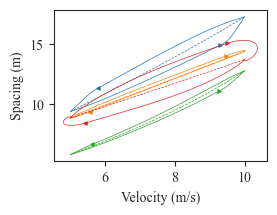

In [7]:
cf_func = cf_IDM_acc_module
cf_e = cf_IDM_equilibrium_module

%matplotlib inline
mm = 1 / 25.4  # mm转inch
fontsize = 10  # 7磅/pt/point
_width = 70 * mm  # 图片宽度英寸
_ratio = 5 / 7  # 图片长宽比
figsize = (_width, _width * _ratio)

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax: plt.Axes = ax
fig: plt.Figure = fig

for type in ["NN", "NP", "PN", "PP"]:
    cf_param_copy = median_param.loc[type].to_dict()
    result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, _, _) = single_run(cf_func, cf_param_copy, cf_e)
    temp: list[plt.Line2D] = ax.plot(dec_v, dec_s, linewidth=0.5)
    ax.plot(acc_v, acc_s, color=temp[-1].get_color(), label=type, linewidth=0.5)
    ax.set_xlabel("Velocity (m/s)", fontsize=fontsize)
    ax.set_ylabel("Spacing (m)", fontsize=fontsize)
    ax.plot(np.linspace(5, 10, 10), cf_e(**cf_param_copy, speed=np.linspace(5, 10, 10)), color=temp[-1].get_color(), linestyle="--", linewidth=0.5)
    # 绘制前车完成减速时的后车状态
    ax.scatter(dec_v[100], dec_s[100], color=temp[-1].get_color(), marker="<", s=5)
    ax.scatter(acc_v[100], acc_s[100], color=temp[-1].get_color(), marker=">", s=5)

fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\median_param_hys.tif", dpi=500, pil_kwargs={"compression": "tiff_lzw"})

In [30]:
def run(cf_func, cf_e, name):
    mm = 1 / 25.4  # mm转inch
    fontsize = 10  # 7磅/pt/point
    _width = 70 * 2 * mm  # 图片宽度英寸
    _ratio = 5 / 14  # 图片长宽比
    figsize = (_width, _width * _ratio)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes: list[plt.Axes] = axes.flatten()
    fig: plt.Figure = fig
    
    cf_param_copy = cf_param.copy()
    if name == "Z":
        cf_param_copy["d"] = 1000
    result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv) = single_run(cf_func, cf_param_copy, cf_e, cal_vs=False)

    dec_steps = 300
    line_width = 0.5

    ax = axes[0]
    # 绘制模型加速度输出
    temp: list[plt.Line2D] = ax.plot(np.arange(len(dec_a[:dec_steps])) * 0.1, dec_a[:dec_steps], label=f"$f$", linewidth=line_width)

    # 绘制模块加速度输出
    time_full = np.arange(len(dec_v[:dec_steps])) * 0.1

    acc_value = np.ones((len(time_full), )) * cf_param_copy["omega"]

    ax.plot(time_full, acc_value, linestyle="-.", label=f"$\omega$", linewidth=line_width)

    if "V" in name:
        dec_kv = IDM_v_module(**cf_param_copy, speed=dec_v[:dec_steps])
        acc_value -= dec_kv
        ax.plot(time_full, dec_kv, linestyle="--", label=f"$V$", linewidth=line_width)

    if "S" in name:
        dec_ks = IDM_s_module(**cf_param_copy, speed=dec_v[:dec_steps], gap=dec_s[:dec_steps])
        acc_value -= np.power(dec_ks, 2)
        ax.plot(time_full, np.power(dec_ks, 2), linestyle=":", label=f"$S^2$", linewidth=line_width)

    if "Z" in name:
        dec_kz = IDM_z_module(**cf_param_copy, speed=dec_v[:dec_steps], leaderV=dec_lv[:dec_steps], gap=dec_s[:dec_steps])
        acc_value -= np.power(dec_kz, 2)
        if name == "Z":
            ax.plot(time_full, dec_kz, linestyle="-.", label=f"$Z$", linewidth=line_width)
        else:
            ax.plot(time_full, np.power(dec_kz, 2), linestyle="-.", label=f"$Z^2$", linewidth=line_width)

    if "S" in name and "Z" in name:
        acc_value -= 2 * dec_kz * dec_ks
        ax.plot(time_full, 2 * dec_kz * dec_ks, linestyle="-.", label=f"$2ZS$", linewidth=line_width)

    ax.legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=2, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

    ax.set_xlabel("Time (s)", fontsize=fontsize)
    ax.set_ylabel("Acceleration (m/s$^2$)", fontsize=fontsize)


    ax = axes[1]
    time_full = len(dec_v) * 0.1 + np.arange(len(acc_v[:dec_steps])) * 0.1
    # 绘制模型加速度输出
    temp: list[plt.Line2D] = ax.plot(time_full, acc_a[:dec_steps], label=f"$f$", linewidth=line_width)

    acc_value = np.ones((len(time_full), )) * cf_param_copy["omega"]

    ax.plot(time_full, acc_value, linestyle="-.", label=f"$\omega$", linewidth=line_width)

    # 绘制模块加速度输出
    if "V" in name:
        acc_kv = IDM_v_module(**cf_param_copy, speed=acc_v[:dec_steps])
        acc_value -= acc_kv
        ax.plot(time_full, acc_kv, linestyle="--", label=f"$V$", linewidth=line_width)

    if "S" in name:
        acc_ks = IDM_s_module(**cf_param_copy, speed=acc_v[:dec_steps], gap=acc_s[:dec_steps])
        acc_value -= np.power(acc_ks, 2)
        ax.plot(time_full, np.power(acc_ks, 2), linestyle=":", label=f"$S^2$", linewidth=line_width)

    if "Z" in name:
        acc_kz = IDM_z_module(**cf_param_copy, speed=acc_v[:dec_steps], leaderV=acc_lv[:dec_steps], gap=acc_s[:dec_steps])
        acc_value -= np.power(acc_kz, 2)
        # ax.plot(time_full, acc_value, linestyle="-.", label=f"$Z^2_4(\cdot)$", linewidth=line_width)
        if name == "Z":
            ax.plot(time_full, acc_kz, linestyle="-.", label=f"$Z$", linewidth=line_width)
        else:
            ax.plot(time_full, np.power(acc_kz, 2), linestyle="-.", label=f"$Z^2$", linewidth=line_width)

    if "S" in name and "Z" in name:
        acc_value -= 2 * acc_kz * acc_ks
        # ax.plot(time_full, acc_value, linestyle="-.", label=f"$2ZS_5(\cdot)$", linewidth=line_width)
        ax.plot(time_full, 2 * acc_kz * acc_ks, linestyle="-.", label=f"$2ZS$", linewidth=line_width)


    ax.legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=2, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

    ax.set_xlabel("Time (s)", fontsize=fontsize)

    fig.subplots_adjust(bottom=0.23, top=0.95, left=0.1, right=0.99)

    fig.savefig(fr"E:\PyProject\car-following-model-test\tests\data\module_{name}_IDM.tif", dpi=500, pil_kwargs={"compression": "tiff_lzw"})

In [51]:
def run_sv(cf_func, cf_e, type, fig=None, ax=None):
    fontsize = 10  # 7磅/pt/point
    if fig is None or ax is None:
        mm = 1 / 25.4  # mm转inch
        _width = 70 * mm  # 图片宽度英寸
        _ratio = 5 / 7  # 图片长宽比
        figsize = (_width, _width * _ratio)
    
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        fig: plt.Figure = fig
        ax: plt.Axes = ax

    cf_param_copy = cf_param.copy()
    result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv) = single_run(cf_func, cf_param_copy, cf_e, cal_vs=False)
    
    temp = ax.plot(dec_v, dec_s, label=type, linewidth=0.5)
    ax.plot(acc_v, acc_s, color=temp[-1].get_color(), linewidth=0.5)
    ax.scatter(dec_v[100], dec_s[100], color=temp[-1].get_color(), marker="<", s=5)
    ax.scatter(acc_v[100], acc_s[100], color=temp[-1].get_color(), marker=">", s=5)
    
    ax.set_xlabel("Spacing (m)", fontsize=fontsize)
    ax.set_ylabel("Velocity (m/s)", fontsize=fontsize)
    
    if "S" in type:
        ax.plot(np.linspace(5, 10, 10), cf_e(**cf_param_copy, speed=np.linspace(5, 10, 10)), color=temp[-1].get_color(), linestyle="--", linewidth=0.5)
        
    ax.legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=2, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)
    
    dec_V = IDM_v_module(**cf_param_copy, speed=dec_v)
    dec_S = IDM_s_module(**cf_param_copy, speed=dec_v, gap=dec_s)
    dec_Z = IDM_z_module(**cf_param_copy, speed=dec_v, leaderV=dec_lv, gap=dec_s)
    
    acc_V = IDM_v_module(**cf_param_copy, speed=acc_v)
    acc_S = IDM_s_module(**cf_param_copy, speed=acc_v, gap=acc_s)
    acc_Z = IDM_z_module(**cf_param_copy, speed=acc_v, leaderV=acc_lv, gap=acc_s)
    
    return dec_V, dec_S, dec_Z, acc_V, acc_S, acc_Z, dec_s, dec_v, acc_s, acc_v, dec_a, acc_a

# Full

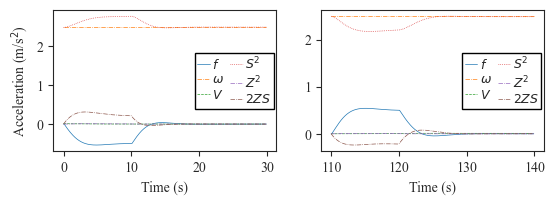

In [158]:
%matplotlib inline

cf_func = cf_IDM_acc_module
cf_e = cf_IDM_equilibrium_module

run(cf_func, cf_e, "VSZ")

# VS_IDM

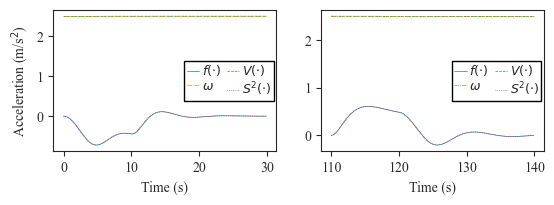

In [12]:
from trasim_simplified.core.kinematics.cfm.CFM_IDM_VS import cf_IDM_VS_acc, cf_IDM_VS_equilibrium

cf_func = cf_IDM_VS_acc
cf_e = cf_IDM_VS_equilibrium

run(cf_func, cf_e, "VS")

# Z_IDM

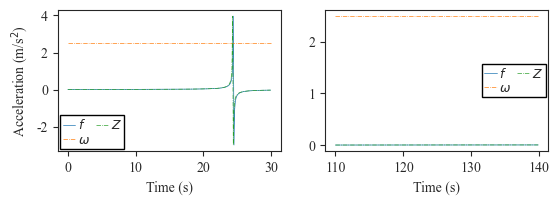

In [31]:
from trasim_simplified.core.kinematics.cfm.CFM_IDM_Z import cf_IDM_Z_acc, cf_IDM_Z_equilibrium

cf_func = cf_IDM_Z_acc
cf_e = None

run(cf_func, cf_e, "Z")

# S_IDM

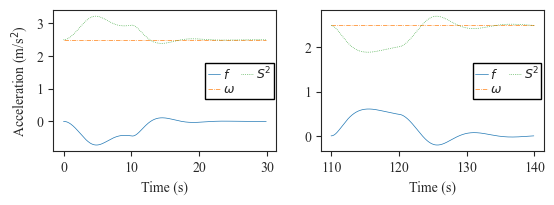

In [9]:
from trasim_simplified.core.kinematics.cfm.CFM_IDM_S import cf_IDM_S_acc, cf_IDM_S_equilibrium

cf_func = cf_IDM_S_acc
cf_e = cf_IDM_S_equilibrium

run(cf_func, cf_e, "S")

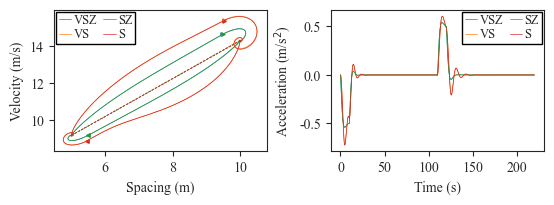

In [52]:
from trasim_simplified.core.kinematics.cfm.CFM_IDM_VS import cf_IDM_VS_acc, cf_IDM_VS_equilibrium
from trasim_simplified.core.kinematics.cfm.CFM_IDM_Z import cf_IDM_Z_acc, cf_IDM_Z_equilibrium
from trasim_simplified.core.kinematics.cfm.CFM_IDM_SZ import cf_IDM_SZ_acc, cf_IDM_SZ_equilibrium
from trasim_simplified.core.kinematics.cfm.CFM_IDM_S import cf_IDM_S_acc, cf_IDM_S_equilibrium

mm = 1 / 25.4  # mm转inch
fontsize = 10  # 7磅/pt/point
_width = 70 * 2 * mm  # 图片宽度英寸
_ratio = 5 / 14  # 图片长宽比
figsize = (_width, _width * _ratio)

fig, ax = plt.subplots(1, 2, figsize=figsize)
fig: plt.Figure = fig
axes: list[plt.Axes] = ax.flatten()

VSZ_result = run_sv(cf_IDM_acc_module, cf_IDM_equilibrium_module, "VSZ", fig, axes[0])
VS_result = run_sv(cf_IDM_VS_acc, cf_IDM_VS_equilibrium, "VS", fig, axes[0])
SZ_result = run_sv(cf_IDM_SZ_acc, cf_IDM_SZ_equilibrium, "SZ", fig, axes[0])
S_result = run_sv(cf_IDM_S_acc, cf_IDM_S_equilibrium, "S", fig, axes[0])

dec_time = np.arange(len(VSZ_result[-2])) * 0.1
acc_time = len(VSZ_result[-2]) * 0.1 + np.arange(len(VSZ_result[-1])) * 0.1

axes[1].plot(dec_time, VSZ_result[-2], label="VSZ", linewidth=0.5)
axes[1].plot(acc_time, VSZ_result[-1], linewidth=0.5, color=axes[1].get_lines()[-1].get_color())
axes[1].plot(dec_time, VS_result[-2], label="VS", linewidth=0.5)
axes[1].plot(acc_time, VS_result[-1], linewidth=0.5, color=axes[1].get_lines()[-1].get_color())
axes[1].plot(dec_time, SZ_result[-2], label="SZ", linewidth=0.5)
axes[1].plot(acc_time, SZ_result[-1], linewidth=0.5, color=axes[1].get_lines()[-1].get_color())
axes[1].plot(dec_time, S_result[-2], label="S", linewidth=0.5)
axes[1].plot(acc_time, S_result[-1], linewidth=0.5, color=axes[1].get_lines()[-1].get_color())

axes[1].set_xlabel("Time (s)", fontsize=fontsize)
axes[1].set_ylabel("Acceleration (m/s$^2$)", fontsize=fontsize)

axes[1].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=2, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)


fig.subplots_adjust(bottom=0.23, top=0.95, left=0.1, right=0.99, wspace=0.3)
fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_sv_IDM.tif", dpi=500, pil_kwargs={"compression": "tiff_lzw"})

# 计算实测迟滞强度与模块加速度贡献的关系

In [5]:
df_clb: dict[str, pd.DataFrame] = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_traj_s" + f"_{cf_name}.pkl")
df_param: pd.DataFrame = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_param_df" + f"_{cf_name}.pkl")
ids = list(df_clb["dec"].keys())

In [30]:
# 求解模块加速度贡献
def cal_module_acc(id_):
    cf_param = {name: df_param[df_param[TI.Pair_ID] == id_][name].iloc[0] for name in param_names}
    l_length = df_clb["dec"][id_][Prefix.leader + TI.v_Length].iloc[0]
    df_dec = df_clb["dec"][id_]
    df_acc = df_clb["acc"][id_]
    
    dec_v = IDM_v_module(omega=cf_param["omega"], v0=cf_param["v0"], delta=cf_param["delta"], speed=df_dec[TI.v], l_length=l_length)
    dec_s = IDM_s_module(omega=cf_param["omega"], s0=cf_param["s0"], T=cf_param["T"], speed=df_dec[TI.v], gap=df_dec[TI.gap])
    dec_z = IDM_z_module(d=cf_param["d"], speed=df_dec[TI.v], leaderV=df_dec[Prefix.leader + TI.v], gap=df_dec[TI.gap])
    
    acc_v = IDM_v_module(omega=cf_param["omega"], v0=cf_param["v0"], delta=cf_param["delta"], speed=df_acc[TI.v], l_length=l_length)
    acc_s = IDM_s_module(omega=cf_param["omega"], s0=cf_param["s0"], T=cf_param["T"], speed=df_acc[TI.v], gap=df_acc[TI.gap])
    acc_z = IDM_z_module(d=cf_param["d"], speed=df_acc[TI.v], leaderV=df_acc[Prefix.leader + TI.v], gap=df_acc[TI.gap])

    sv_result = cal_sv_intensity(
        df_dec[Prefix.leader + TI.x] - df_dec[TI.x] - l_length, df_dec[TI.v], df_acc[Prefix.leader + TI.x] - df_acc[TI.x] - l_length, df_acc[TI.v], cf_IDM_equilibrium_module, cf_param)
    
    return id_, df_acc[TI.a].mean(), df_dec[TI.a].mean(), np.mean(acc_v), np.mean(np.power(acc_s, 2)), np.mean(np.power(acc_z, 2)), np.mean(2 * acc_s * acc_z), np.mean(dec_v), np.mean(np.power(dec_s, 2)), np.mean(np.power(dec_z, 2)), np.mean(2 * dec_s * dec_z), sv_result["total_vs"], sv_result["dec_vs"], sv_result["acc_vs"]

In [31]:
import joblib
from tqdm import tqdm

tqdm_iter = tqdm(ids)
tqdm_iter.reset()

result = joblib.Parallel(n_jobs=-1)(joblib.delayed(cal_module_acc)(id_) for id_ in tqdm_iter)


100%|██████████| 262/262 [00:17<00:00, 14.57it/s]


In [127]:
df_module = pd.DataFrame(result, columns=["pair_id", "acc", "dec", "acc_v", "acc_s", "acc_z", "acc_2sz", "dec_v", "dec_s", "dec_z", "dec_2sz", "total_vs", "dec_vs", "acc_vs"])
df_module.sort_values("pair_id").reset_index(drop=True, inplace=True)
df_param.sort_values(TI.Pair_ID).reset_index(drop=True, inplace=True)
df_module = pd.concat(axis=1, objs=[df_module, df_param])
df_module["dec_V"] = df_module["omega"] - df_module["dec_v"]
df_module["acc_V"] = df_module["omega"] - df_module["acc_v"]
df_module["dec_VS"] = df_module["dec_V"] - df_module["dec_s"]
df_module["acc_VS"] = df_module["acc_V"] - df_module["acc_s"]
df_module["dec_VSZ"] = df_module["dec_VS"] - df_module["dec_z"]
df_module["acc_VSZ"] = df_module["acc_VS"] - df_module["acc_z"]
df_module["dec_VSZ2"] = df_module["dec_VSZ"] - df_module["dec_2sz"]
df_module["acc_VSZ2"] = df_module["acc_VSZ"] - df_module["acc_2sz"]
df_module

,pair_id,acc,dec,acc_v,acc_s,acc_z,acc_2sz,dec_v,dec_s,dec_z,...,Pair_ID,ObjV,dec_V,acc_V,dec_VS,acc_VS,dec_VSZ,acc_VSZ,dec_VSZ2,acc_VSZ2
0,246,0.486490,-0.409891,9.103462e-06,0.933315,0.004619,-0.109609,6.233367e-08,1.515355,0.021521,...,246,11.514163,1.320260,1.320251,-0.195095,0.386936,-0.216616,0.382317,-0.403878,0.491926
1,249,0.704643,-0.561221,2.742357e-01,0.835410,0.017737,-0.205567,1.709328e-01,1.737886,0.013911,...,249,9.647488,1.495571,1.392268,-0.242315,0.556858,-0.256227,0.539122,-0.528517,0.744689
2,250,0.632651,-0.579987,2.606628e-01,2.173430,0.013088,-0.308054,5.515675e-02,3.129201,0.012683,...,250,7.231744,2.741753,2.536247,-0.387447,0.362817,-0.400130,0.349730,-0.615358,0.657784
3,251,0.801474,-0.457460,5.220436e-02,1.154505,0.008747,-0.182670,3.073545e-02,2.287013,0.007008,...,251,17.875899,1.799595,1.778126,-0.487418,0.623621,-0.494426,0.614874,-0.609428,0.797545
4,255,0.863220,-0.475236,9.985247e-02,1.518006,0.057213,-0.506759,9.519119e-03,2.184452,0.024376,...,255,11.664526,2.026482,1.936149,-0.157970,0.418143,-0.182346,0.360929,-0.416252,0.867688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,18663,0.544400,-0.429947,3.989715e-01,0.841101,0.037437,-0.335316,3.185041e-01,1.146439,0.051761,...,18663,10.245373,1.137155,1.056687,-0.009285,0.215586,-0.061046,0.178149,-0.353751,0.513465
258,18666,0.545403,-0.324647,1.135576e-05,2.850105,0.343868,-1.199581,6.568373e-07,5.714588,0.335366,...,18666,29.815117,2.788289,2.788279,-2.926298,-0.061826,-3.261664,-0.405695,-4.342581,0.793886
259,18667,0.514331,-0.401127,1.821397e-06,2.142602,0.010153,-0.209267,1.961789e-07,2.654902,0.013451,...,18667,22.968768,2.387088,2.387086,-0.267814,0.244485,-0.281265,0.234331,-0.481278,0.443598
260,18668,0.658208,-0.296710,1.200958e-06,0.368989,0.026240,-0.154751,6.898055e-08,1.082379,0.046323,...,18668,33.588205,0.894095,0.894094,-0.188283,0.525105,-0.234606,0.498866,-0.349653,0.653617


In [128]:
num_intervals = 20
df_module['dec_vs_interval'], bins_dec = pd.cut(df_module['dec_vs'], bins=num_intervals, labels=False, retbins=True)
df_module['acc_vs_interval'], bins_acc = pd.cut(df_module['acc_vs'], bins=num_intervals, labels=False, retbins=True)
df_module

,pair_id,acc,dec,acc_v,acc_s,acc_z,acc_2sz,dec_v,dec_s,dec_z,...,dec_V,acc_V,dec_VS,acc_VS,dec_VSZ,acc_VSZ,dec_VSZ2,acc_VSZ2,dec_vs_interval,acc_vs_interval
0,246,0.486490,-0.409891,9.103462e-06,0.933315,0.004619,-0.109609,6.233367e-08,1.515355,0.021521,...,1.320260,1.320251,-0.195095,0.386936,-0.216616,0.382317,-0.403878,0.491926,12,6
1,249,0.704643,-0.561221,2.742357e-01,0.835410,0.017737,-0.205567,1.709328e-01,1.737886,0.013911,...,1.495571,1.392268,-0.242315,0.556858,-0.256227,0.539122,-0.528517,0.744689,11,5
2,250,0.632651,-0.579987,2.606628e-01,2.173430,0.013088,-0.308054,5.515675e-02,3.129201,0.012683,...,2.741753,2.536247,-0.387447,0.362817,-0.400130,0.349730,-0.615358,0.657784,11,4
3,251,0.801474,-0.457460,5.220436e-02,1.154505,0.008747,-0.182670,3.073545e-02,2.287013,0.007008,...,1.799595,1.778126,-0.487418,0.623621,-0.494426,0.614874,-0.609428,0.797545,12,6
4,255,0.863220,-0.475236,9.985247e-02,1.518006,0.057213,-0.506759,9.519119e-03,2.184452,0.024376,...,2.026482,1.936149,-0.157970,0.418143,-0.182346,0.360929,-0.416252,0.867688,11,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,18663,0.544400,-0.429947,3.989715e-01,0.841101,0.037437,-0.335316,3.185041e-01,1.146439,0.051761,...,1.137155,1.056687,-0.009285,0.215586,-0.061046,0.178149,-0.353751,0.513465,10,4
258,18666,0.545403,-0.324647,1.135576e-05,2.850105,0.343868,-1.199581,6.568373e-07,5.714588,0.335366,...,2.788289,2.788279,-2.926298,-0.061826,-3.261664,-0.405695,-4.342581,0.793886,5,2
259,18667,0.514331,-0.401127,1.821397e-06,2.142602,0.010153,-0.209267,1.961789e-07,2.654902,0.013451,...,2.387088,2.387086,-0.267814,0.244485,-0.281265,0.234331,-0.481278,0.443598,12,4
260,18668,0.658208,-0.296710,1.200958e-06,0.368989,0.026240,-0.154751,6.898055e-08,1.082379,0.046323,...,0.894095,0.894094,-0.188283,0.525105,-0.234606,0.498866,-0.349653,0.653617,15,11


In [129]:
bins_dec_middle: np.ndarray = bins_dec[:-1] + np.diff(bins_dec) / 2
indexes = df_module["dec_vs_interval"].unique()
indexes.sort()
bins_dec_middle = bins_dec_middle[indexes]
bins_dec_width = np.diff(bins_dec)[0]

bins_acc_middle: np.ndarray = bins_acc[:-1] + np.diff(bins_acc) / 2
indexes = df_module["acc_vs_interval"].unique()
indexes.sort()
bins_acc_middle = bins_acc_middle[indexes]
bins_acc_width = np.diff(bins_acc)[0]

bins_dec_middle

array([-5.63107357, -3.83134702, -3.23343122, -2.63551542, -2.03759962,
       -1.43968382, -0.84176802, -0.24385222,  0.35406358,  0.95197938,
        1.54989517,  2.14781097,  2.74572677,  3.34364257,  3.94155837,
        4.53947417,  5.13738997,  5.73530577])

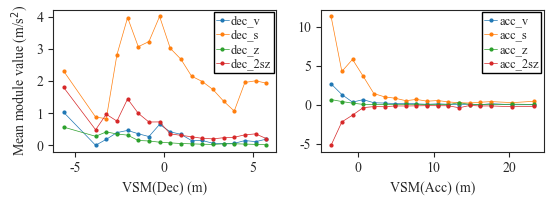

In [143]:
%matplotlib inline

mm = 1 / 25.4  # mm转inch
_width = 70 * 2 * mm  # 图片宽度英寸
_ratio = 5 / 14  # 图片长宽比
figsize = (_width, _width * _ratio)
fontsize = 10  # 7磅/pt/point

fig, axes = plt.subplots(1, 2, figsize=figsize)
axes: list[plt.Axes] = axes.flatten()
fig: plt.Figure = fig

dec_interval_means = df_module.groupby('dec_vs_interval').mean().reset_index()
for i, col in enumerate(["dec_omega", 'dec_v', 'dec_s', 'dec_z', 'dec_2sz']):
    # axes[0].bar(bins_dec_middle, dec_interval_means[col], label=col, width=bins_dec_width - i * bins_dec_width / 5, linewidth=0, edgecolor=None)
    axes[0].plot(bins_dec_middle, dec_interval_means[col], label=col, marker="o", markersize=2, linewidth=0.5)

axes[0].set_ylabel("Mean module value (m/s$^2$)", fontsize=fontsize)
axes[0].set_xlabel("VSM(Dec) (m)", fontsize=fontsize)
axes[0].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

acc_interval_means = df_module.groupby('acc_vs_interval').mean().reset_index()
for col in ["acc_omega", 'acc_v', 'acc_s', 'acc_z', 'acc_2sz']:
    # axes[1].bar(bins_acc_middle, acc_interval_means[col], label=col, width=bins_acc_width)
    axes[1].plot(bins_acc_middle, acc_interval_means[col], label=col, marker="o", markersize=2, linewidth=0.5)

axes[1].set_xlabel("VSM(Acc) (m)", fontsize=fontsize)
axes[1].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

fig.subplots_adjust(bottom=0.23, top=0.95, left=0.1, right=0.99)
fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_mean_IDM.tif", dpi=500, pil_kwargs={"compression": "tiff_lzw"})

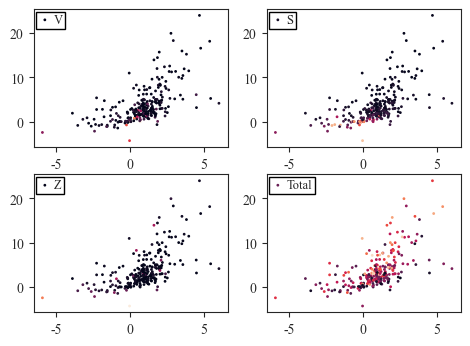

In [13]:
mm = 1 / 25.4  # mm转inch
_width = 70 * 2 * mm  # 图片宽度英寸
_ratio = 5 / 7  # 图片长宽比
figsize = (_width, _width * _ratio)
fontsize = 10  # 7磅/pt/point

fig, axes = plt.subplots(2, 2, figsize=figsize)
axes: list[plt.Axes] = axes.flatten()
fig: plt.Figure = fig

axes[0].scatter(df_module["dec_vs"], df_module["acc_vs"], c=df_module["acc_v"], label="V", s=1)
axes[0].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

axes[1].scatter(df_module["dec_vs"], df_module["acc_vs"], c=np.power(df_module["acc_s"], 2), label="S", s=1)
axes[1].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

axes[2].scatter(df_module["dec_vs"], df_module["acc_vs"], c=np.power(df_module["acc_z"], 2), label="Z", s=1)
axes[2].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

axes[3].scatter(df_module["dec_vs"], df_module["acc_vs"], c=df_module["acc"], label="Total", s=1)
axes[3].legend(fontsize=fontsize - 1, frameon=True, framealpha=1, edgecolor="k", ncol=1, fancybox=False, shadow=False, borderpad=0.2, labelspacing=0.2, handletextpad=0.2, handlelength=1, columnspacing=0.5, borderaxespad=0.2)

# 网格搜索w、d参数，获取四种迟滞类型对应的参数组合（缺PN类型）

In [16]:
omega_range = np.linspace(0.5, 5, 11)
d_range = np.linspace(0.5, 5, 11)
v0_range = np.linspace(15, 40, 11)


In [15]:
import itertools
from tqdm import tqdm

data = {"id": [], "omega": [], "d": [], "v0": [], "total_vs": [], "dec_vs": [], "acc_vs": [],
        "dec_V": [], "dec_S2": [], "dec_Z2": [], "dec_2SZ": [], "acc_V": [], "acc_S2": [], "acc_Z2": [], "acc_2SZ": [],
        "dec_early_stage_avg_a": [], "dec_early_stage_avg_v": [], "acc_early_stage_avg_a": [], "acc_early_stage_avg_v": []}
id_ = 0
traj_data = {}

for omega, d, v0 in tqdm(itertools.product(omega_range, d_range, v0_range)):
    cf_param_copy = cf_param.copy()
    cf_param_copy.update({"omega": omega, "d": d, "v0": v0, "delta": 1})
    vs_results, (dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_) = single_run(cf_func_=cf_IDM_acc_module, cf_param_=cf_param_copy, cf_e_=cf_IDM_equilibrium_module, cal_vs=True)
    dec_s_ = np.array(dec_s_)
    dec_v_ = np.array(dec_v_)
    acc_s_ = np.array(acc_s_)
    acc_v_ = np.array(acc_v_)
    dec_a_ = np.array(dec_a_)
    acc_a_ = np.array(acc_a_)
    dec_lv_ = np.array(dec_lv_)
    acc_lv_ = np.array(acc_lv_)
    data["total_vs"].append(vs_results["total_vs"])
    data["dec_vs"].append(vs_results["dec_vs"])
    data["acc_vs"].append(vs_results["acc_vs"])
    data["omega"].append(omega)
    data["d"].append(d)
    data["v0"].append(v0)
    data["id"].append(id_)
    traj_data[id_] = (dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_)
    data["dec_V"].append(IDM_v_module(**cf_param_copy, speed=dec_v_[:100]).mean())
    data["dec_S2"].append(IDM_s_module(**cf_param_copy, speed=dec_v_[:100], gap=dec_s_[:100]).mean() ** 2)
    data["dec_Z2"].append(IDM_z_module(**cf_param_copy, speed=dec_v_[:100], leaderV=dec_lv_[:100], gap=dec_s_[:100]).mean() ** 2)
    data["dec_2SZ"].append((2 * IDM_s_module(**cf_param_copy, speed=dec_v_[:100], gap=dec_s_[:100]) * IDM_z_module(**cf_param_copy, speed=dec_v_[:100], leaderV=dec_lv_[:100], gap=dec_s_[:100])).mean())
    
    data["acc_V"].append(IDM_v_module(**cf_param_copy, speed=acc_v_[:100]).mean())
    data["acc_S2"].append(IDM_s_module(**cf_param_copy, speed=acc_v_[:100], gap=acc_s_[:100]).mean() ** 2)
    data["acc_Z2"].append(IDM_z_module(**cf_param_copy, speed=acc_v_[:100], leaderV=acc_lv_[:100], gap=acc_s_[:100]).mean() ** 2)
    data["acc_2SZ"].append((2 * IDM_s_module(**cf_param_copy, speed=acc_v_[:100], gap=acc_s_[:100]) * IDM_z_module(**cf_param_copy, speed=acc_v_[:100], leaderV=acc_lv_[:100], gap=acc_s_[:100])).mean())
    
    data["dec_early_stage_avg_a"].append(dec_a_[:100].mean())
    data["dec_early_stage_avg_v"].append(dec_v_[:100].mean())
    data["acc_early_stage_avg_a"].append(acc_a_[:100].mean())
    data["acc_early_stage_avg_v"].append(acc_v_[:100].mean())
    id_ += 1
df_grid = pd.DataFrame.from_dict(data)
df_grid.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\module_grid_IDM.pkl")
df_grid

1331it [00:17, 78.22it/s]


,id,omega,d,v0,total_vs,dec_vs,acc_vs,dec_V,dec_S2,dec_Z2,dec_2SZ,acc_V,acc_S2,acc_Z2,acc_2SZ,dec_early_stage_avg_a,dec_early_stage_avg_v,acc_early_stage_avg_a,acc_early_stage_avg_v
0,0,0.5,0.5,15.0,9.321867,-0.549898,9.871765,0.285088,0.201195,0.094441,0.281026,0.202483,0.216819,0.127858,-0.311550,-0.369183,8.552646,0.235262,6.074487
1,1,0.5,0.5,17.5,7.747000,-0.147466,7.894466,0.240513,0.253126,0.088069,0.302864,0.175968,0.236432,0.126582,-0.325356,-0.389378,8.417958,0.257954,6.158880
2,2,0.5,0.5,20.0,6.790367,0.035227,6.755140,0.208486,0.290661,0.083256,0.314653,0.155535,0.251788,0.124837,-0.334785,-0.400370,8.339459,0.274982,6.221387
3,3,0.5,0.5,22.5,6.166457,0.135262,6.031195,0.184175,0.319143,0.079672,0.321953,0.139319,0.264124,0.123036,-0.341519,-0.407303,8.287897,0.288133,6.269335
4,4,0.5,0.5,25.0,5.721625,0.196619,5.525006,0.165028,0.341531,0.076938,0.326886,0.126143,0.274244,0.121334,-0.346506,-0.412083,8.251385,0.298540,6.307171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,1326,5.0,5.0,30.0,0.451798,0.190551,0.261247,1.365028,3.727514,0.006996,0.324698,1.139284,3.719515,0.005770,-0.290518,-0.424373,8.190170,0.416726,6.835706
1327,1327,5.0,5.0,32.5,0.446216,0.188790,0.257426,1.256905,3.839716,0.006757,0.323659,1.054011,3.802581,0.005632,-0.290442,-0.426492,8.169880,0.419537,6.851072
1328,1328,5.0,5.0,35.0,0.441288,0.187147,0.254141,1.164777,3.935165,0.006563,0.322767,0.980545,3.874187,0.005516,-0.290330,-0.428190,8.153436,0.421831,6.863814
1329,1329,5.0,5.0,37.5,0.436777,0.185607,0.251170,1.085312,4.017383,0.006403,0.321996,0.916606,3.936536,0.005418,-0.290201,-0.429584,8.139841,0.423737,6.874544


In [113]:
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

v015 = df_grid[df_grid["v0"] == 15]
v025 = df_grid[df_grid["v0"] == 25]
v035 = df_grid[df_grid["v0"] == 35]

def run_3_param(vs_type="total_vs"):
    name = vs_type.split("_")[0]
    clabel = f"VSM({name}) (m)" if vs_type.split("_")[-1] == "vs" else vs_type
    target_level = [0] if vs_type.split("_")[-1] == "vs" else 5
    mm = 1 / 25.4  # mm转inch
    _width = 70 * 2 * mm  # 图片宽度英寸
    _ratio = 5 / 14  # 图片长宽比
    figsize = (_width, _width * _ratio)
    fontsize = 10  # 7磅/pt/point
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes: list[plt.Axes] = axes.flatten()
    fig: plt.Figure = fig
    
    # vmin = np.min([v015["dec_vs"].min(), v025["dec_vs"].min(), v035["dec_vs"].min(), v015["acc_vs"].min(), v025["acc_vs"].min(), v035["acc_vs"].min()])
    # vmax = np.max([v015["dec_vs"].max(), v025["dec_vs"].max(), v035["dec_vs"].max(), v015["acc_vs"].max(), v025["acc_vs"].max(), v035["acc_vs"].max()])
    vmin = np.min([v015[vs_type].min(), v025[vs_type].min(), v035[vs_type].min()])
    vmax = np.max([v015[vs_type].max(), v025[vs_type].max(), v035[vs_type].max()])
    
    axes[0].contourf(v015["omega"].values.reshape(11, 11), v015["d"].values.reshape(11, 11), v015[vs_type].values.reshape(11, 11), cmap="jet", levels=np.linspace(vmin, vmax, 100), vmin=vmin, vmax=vmax)
    contour = axes[0].contour(v015["omega"].values.reshape(11, 11), v015["d"].values.reshape(11, 11), v015[vs_type].values.reshape(11, 11), levels=target_level, colors='black')
    axes[0].clabel(contour, inline=True, fontsize=fontsize - 1)
    axes[0].set_xlabel("$\omega$", fontsize=fontsize)
    axes[0].set_ylabel("$d$", fontsize=fontsize)
    axes[0].set_title(f"{name} v0 = 15m/s", fontsize=fontsize)
    
    axes[1].contourf(v025["omega"].values.reshape(11, 11), v025["d"].values.reshape(11, 11), v025[vs_type].values.reshape(11, 11), cmap="jet", levels=np.linspace(vmin, vmax, 100), vmin=vmin, vmax=vmax)
    contour = axes[1].contour(v025["omega"].values.reshape(11, 11), v025["d"].values.reshape(11, 11), v025[vs_type].values.reshape(11, 11), levels=target_level, colors='black')
    axes[1].clabel(contour, inline=True, fontsize=fontsize - 1)
    axes[1].set_xlabel("$\omega$", fontsize=fontsize)
    axes[1].set_title(f"{name} v0 = 25m/s", fontsize=fontsize)
    
    CS = axes[2].contourf(v035["omega"].values.reshape(11, 11), v035["d"].values.reshape(11, 11), v035[vs_type].values.reshape(11, 11), cmap="jet", levels=np.linspace(vmin, vmax, 100), vmin=vmin, vmax=vmax)
    contour = axes[2].contour(v035["omega"].values.reshape(11, 11), v035["d"].values.reshape(11, 11), v035[vs_type].values.reshape(11, 11), levels=target_level, colors='black')
    axes[2].clabel(contour, inline=True, fontsize=fontsize - 1)
    axes[2].set_xlabel("$\omega$", fontsize=fontsize)
    axes[2].set_title(f"{name} v0 = 35m/s", fontsize=fontsize)

    fig.subplots_adjust(bottom=0.23, top=0.9, left=0.08, right=0.90, wspace=0.15)
    cb = fig.colorbar(CS, ax=axes, orientation='vertical', fraction=0.02, pad=0.02,  format=FormatStrFormatter('%.1f'))
    cb.locator = MaxNLocator(nbins=5)  # 限制为最多5个刻度
    cb.update_ticks()
    cb.set_label(clabel, fontsize=fontsize)
    fig.savefig(rf"E:\PyProject\car-following-model-test\tests\data\module_{vs_type}_IDM.tif", dpi=500, pil_kwargs={"compression": "tiff_lzw"})

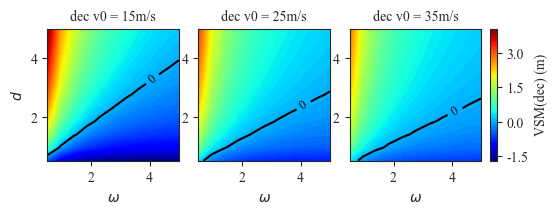

In [106]:
run_3_param("dec_vs")

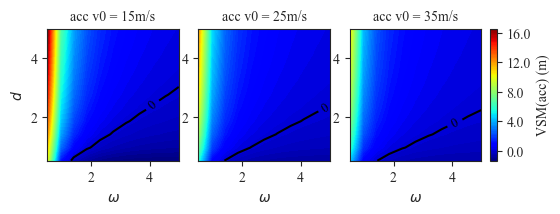

In [107]:
run_3_param("acc_vs")

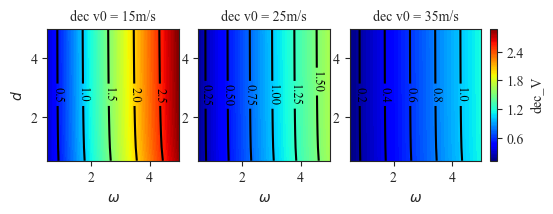

In [114]:
run_3_param("dec_V")

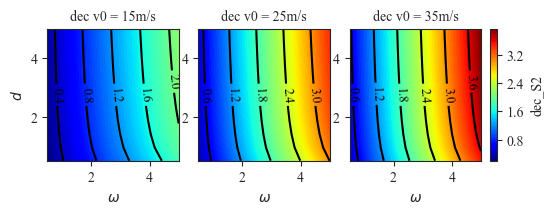

In [115]:
run_3_param("dec_S2")

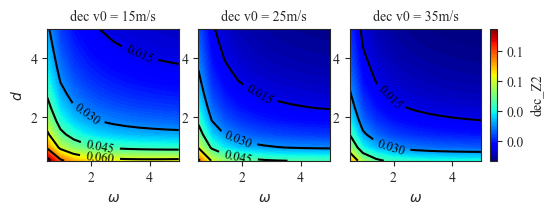

In [116]:
run_3_param("dec_Z2")

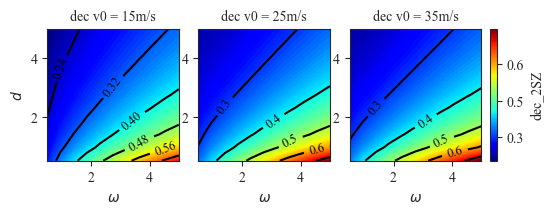

In [117]:
run_3_param("dec_2SZ")

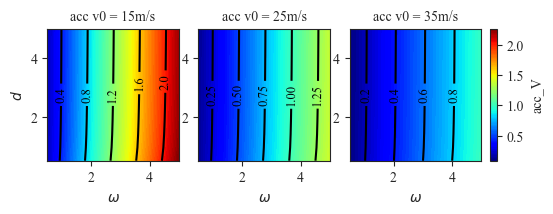

In [118]:
run_3_param("acc_V")

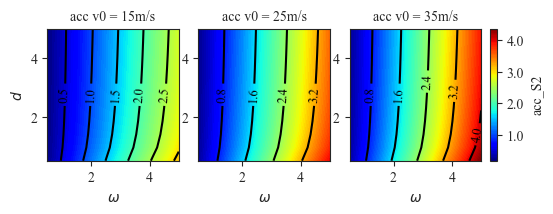

In [119]:
run_3_param("acc_S2")

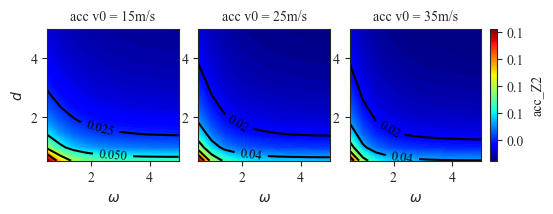

In [120]:
run_3_param("acc_Z2")

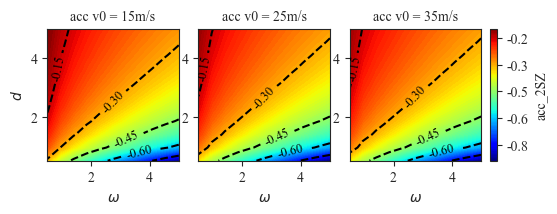

In [121]:
run_3_param("acc_2SZ")

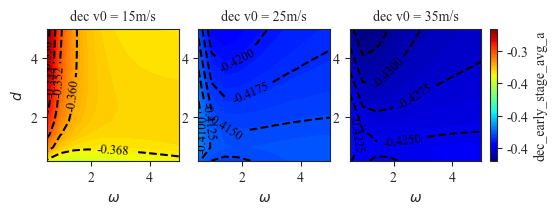

In [122]:
run_3_param("dec_early_stage_avg_a")

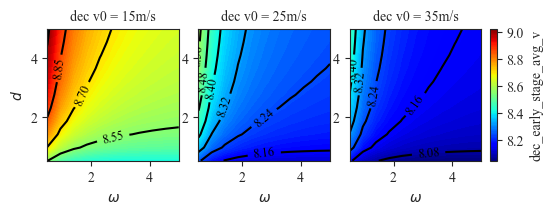

In [123]:
run_3_param("dec_early_stage_avg_v")

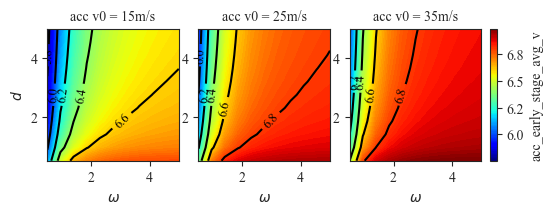

In [124]:
run_3_param("acc_early_stage_avg_v")

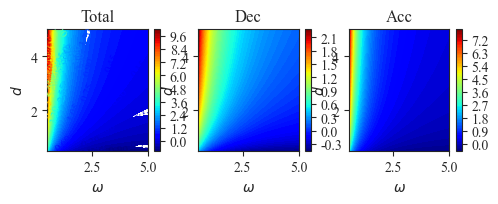

In [74]:
from matplotlib.colorbar import Colorbar

dec_vs = df_grid["dec_vs"].values.reshape(omega_mesh.shape)
acc_vs = df_grid["acc_vs"].values.reshape(omega_mesh.shape)
total_vs = df_grid["total_vs"].values.reshape(omega_mesh.shape)

%matplotlib inline
mm = 1 / 25.4  # mm转inch
fontsize = 10  # 7磅/pt/point
_width = 70 * 2 * mm  # 图片宽度英寸
_ratio = 4 / 14  # 图片长宽比
figsize = (_width, _width * _ratio)
# plt.imshow(dec_vs, extent=[0.1, 10, 0.1, 10], origin="lower", cmap="jet")
fig, axes = plt.subplots(1, 3, figsize=figsize)
axes: list[plt.Axes] = axes.flatten()
fig: plt.Figure = fig

# 将三幅图的colormap根据total_vs,dec_vs以及acc_vs的范围设置为最大的范围
cmap: Colorbar = plt.cm.ScalarMappable(cmap="jet")
cmap.set_array([np.min([np.min(total_vs), np.min(dec_vs), np.min(acc_vs)]), np.max([np.max(total_vs), np.max(dec_vs), np.max(acc_vs)])])

CS = axes[0].contourf(omega_mesh, d_mesh, total_vs, cmap="jet", levels=100)
# 显示等高线数值
plt.clabel(CS, inline=True, fontsize=8)
axes[0].set_xlabel("$\omega$")
axes[0].set_ylabel("$d$")
axes[0].set_title("Total")
plt.colorbar(CS, ax=axes[0])

CS = axes[1].contourf(omega_mesh, d_mesh, dec_vs, cmap="jet", levels=100)
axes[1].set_xlabel("$\omega$")
axes[1].set_ylabel("$d$")
axes[1].set_title("Dec")
plt.colorbar(CS, ax=axes[1])

CS = axes[2].contourf(omega_mesh, d_mesh, acc_vs, cmap="jet", levels=100)
axes[2].set_xlabel("$\omega$")
axes[2].set_ylabel("$d$")
axes[2].set_title("Acc")
plt.colorbar(CS, ax=axes[2])

In [58]:
# 选取对应迟滞类型中dec和acc绝对值相差最小的参数组合
df_param_merge = df_grid

dec_neg_acc_neg = df_param_merge[(df_param_merge["dec_vs"] < -0.2) & (df_param_merge["acc_vs"] < -0.2)]
dec_neg_acc_pos = df_param_merge[(df_param_merge["dec_vs"] < -0.1) & (df_param_merge["acc_vs"] > 0.1)]
dec_pos_acc_neg = df_param_merge[(df_param_merge["dec_vs"] > 0.2) & (df_param_merge["acc_vs"] < -0.2)]
dec_pos_acc_pos = df_param_merge[(df_param_merge["dec_vs"] > 0.4) & (df_param_merge["acc_vs"] > 0.4)]

nn_param = dec_neg_acc_neg.sort_values("total_vs").iloc[0]

dec_neg_acc_pos["diff"] = np.abs(dec_neg_acc_neg["dec_vs"] - dec_neg_acc_neg["acc_vs"])
np_param = dec_neg_acc_pos.sort_values("diff").iloc[0]
# pn_param = dec_pos_acc_neg.sort_values("total_vs").iloc[0]
dec_pos_acc_pos["diff"] = np.abs(dec_pos_acc_pos["dec_vs"] - dec_pos_acc_pos["acc_vs"])
pp_param = dec_pos_acc_pos.sort_values("diff").iloc[0]
print(nn_param, np_param, pp_param)

omega                   6.3
d                       0.5
total_vs          -0.871349
dec_vs             -0.43327
acc_vs            -0.438079
hys_type    dec_neg_acc_neg
Name: 58, dtype: object omega                   1.2
d                       0.5
total_vs           0.140367
dec_vs            -0.124646
acc_vs             0.265013
hys_type    dec_neg_acc_pos
diff                    NaN
Name: 7, dtype: object omega                   3.6
d                       9.6
total_vs            0.91824
dec_vs             0.400116
acc_vs             0.518124
hys_type    dec_pos_acc_pos
diff               0.118008
Name: 8767, dtype: object


C:\Users\Enze Zhao\AppData\Local\Temp\ipykernel_6096\1805402226.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_neg_acc_pos["diff"] = np.abs(dec_neg_acc_neg["dec_vs"] - dec_neg_acc_neg["acc_vs"])
C:\Users\Enze Zhao\AppData\Local\Temp\ipykernel_6096\1805402226.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec_pos_acc_pos["diff"] = np.abs(dec_pos_acc_pos["dec_vs"] - dec_pos_acc_pos["acc_vs"])


In [57]:
dec_neg_acc_neg

,omega,d,total_vs,dec_vs,acc_vs,hys_type
16,2.1,0.5,-0.532025,-0.318625,-0.213399,dec_neg_acc_neg
17,2.2,0.5,-0.566643,-0.329943,-0.236700,dec_neg_acc_neg
18,2.3,0.5,-0.597392,-0.340117,-0.257275,dec_neg_acc_neg
19,2.4,0.5,-0.624802,-0.349283,-0.275519,dec_neg_acc_neg
20,2.5,0.5,-0.649311,-0.357557,-0.291755,dec_neg_acc_neg
...,...,...,...,...,...,...
763,9.6,1.2,-0.415831,-0.208568,-0.207263,dec_neg_acc_neg
764,9.7,1.2,-0.416458,-0.208822,-0.207637,dec_neg_acc_neg
765,9.8,1.2,-0.417049,-0.209059,-0.207990,dec_neg_acc_neg
766,9.9,1.2,-0.417606,-0.209282,-0.208324,dec_neg_acc_neg
